# Optimal Unitary Gate 

This notebook will serve as a test ground for implementing an optimal unitary gate in a dissapative system.

In [428]:
# Import libraries
import numpy as np

import time

import torch
from torch import nn
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler

from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt

In [429]:
# Mac M1 GPU Support
device = torch.device("cpu")
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [430]:
# Define type for torch
exp_dtype = torch.complex64

# Define Pauli matrices for two level system
sigma_x = torch.tensor([[0,1],[1,0]], dtype=exp_dtype).to(device) 
sigma_y = torch.tensor([[0,-1j],[1j,0]], dtype=exp_dtype).to(device) 
sigma_z = torch.tensor([[1,0],[0,-1]], dtype=exp_dtype).to(device) 
sigma_plus = torch.tensor([[0, 1], [0, 0]], dtype=exp_dtype).to(device) 
sigma_minus = torch.tensor([[0, 0], [1, 0]], dtype=exp_dtype).to(device) 
I = torch.eye(2, dtype=exp_dtype).to(device) 

In [431]:
# Multiple spin operators

def X_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(k), sigma_x
        ), torch.eye(N-(k-1))
    )

def Y_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(k), sigma_y
        ), torch.eye(N-(k-1))
    )

def Z_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(k), sigma_z
        ), torch.eye(N-(k-1))
    )

def sigma_plus_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(k), sigma_plus
        ), torch.eye(N-(k-1))
    )

def sigma_plus_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(k), sigma_minus
        ), torch.eye(N-(k-1))
    )

def U_k(U, k, N):
    return torch.kron(
        torch.kron(
            torch.eye(k), U
        ), torch.eye(N-(k-1))
    )


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


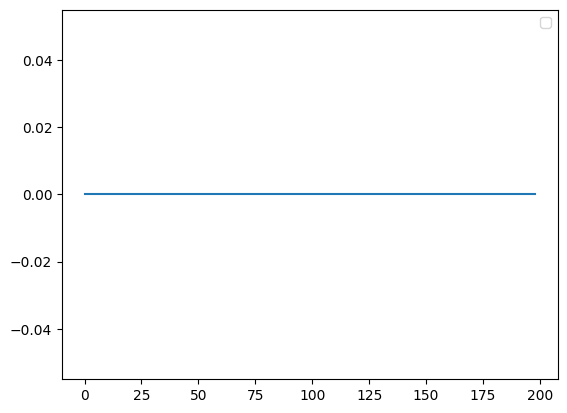

In [432]:
# Dice up the time
Ti, Tf = 0, 1e-6 # seconds
dt = 0.5e-8
t_units = np.arange(Ti, Tf-dt, dt)
M = int((Tf - Ti) // dt)
t = np.arange(M) 

# Number of spins
N = 1
isDispersive = True

# Plotting help
def bloch_animation(rhos, plot=False): 
    x,y,z,r=[],[],[],[] 
    for rho in rhos:
        X = np.real(np.trace(np.dot(rho, np.array([[0, 1], [1, 0]]))))
        Y = np.real(np.trace(np.dot(rho, np.array([[0, -1j], [1j, 0]]))))
        Z = np.real(np.trace(np.dot(rho, np.array([[1, 0], [0, -1]]))))
        R = np.sqrt(X**2 + Y**2 + Z**2)
        x.append(X)
        y.append(Y) 
        z.append(Z)
        r.append(R)

    if plot:
        plt.plot(t_units, x, c='r', label=r"$x(t)$")
        plt.plot(t_units, y, c='b', label=r"$y(t)$")
        plt.plot(t_units, z, c='g', label=r"$z(t)$")
        plt.title("State Vector")
        plt.legend(loc='best')
        plt.savefig("./results/xyz_state.png", dpi=300, bbox_inches="tight")
        plt.show()

        plt.plot(t_units, r, c='k', label=r"$r(t)$")
        plt.title("R Value")
        plt.ylim([0,2])
        plt.legend(loc='best')
        plt.savefig("./results/r_value.png", dpi=300, bbox_inches="tight")
        plt.show()
        print(r)

        print(f"Starting: [{x[0]}, {y[0]}, {z[0]}] \n")
        print(f"Ending: [{x[-1]}, {y[-1]}, {z[-1]}]")
    else:
        return r
    
# Define control parameters
# g = np.zeros(M)
# B_rf = np.zeros(M) 
# phi = np.zeros(M) 
J = np.zeros(M)

# Interpolate to give it some shape
interp_step = M // 2
J_scale = 10000

def interpolate_parameter(param, t, interp_step, scale):
    param[::interp_step] = np.random.rand(M // interp_step + 1) / scale # T
    param[0] = 0
    param[-1] = 0
    param = CubicSpline(t[::interp_step], param[::interp_step])
    return param(t)

# B_rf = interpolate_parameter(B_rf, t, interp_step, scale)
# g = interpolate_parameter(g, t, interp_step, scale)
# if offset_phi:
#     phi = interpolate_parameter(phi, t, interp_step, 1/np.pi)
# J = interpolate_parameter(J, t, interp_step, scale)

# plt.plot(g, label="g")
# plt.plot(B_rf, label="B_rf")
# plt.plot(phi, label="phi")
plt.plot(J)
plt.legend(loc="best")
plt.show()

# Convert to optimization variables with torch properties
J = Variable(torch.tensor(J, dtype=exp_dtype), requires_grad=True)


/var/folders/y1/9bcvzg492znbq7qj0rhkdfp00000gn/T/ipykernel_74440/3017866147.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g = Variable(torch.tensor(g, dtype=exp_dtype), requires_grad=True)
/var/folders/y1/9bcvzg492znbq7qj0rhkdfp00000gn/T/ipykernel_74440/3017866147.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B_rf = Variable(torch.tensor(B_rf, dtype=exp_dtype), requires_grad=True)
/var/folders/y1/9bcvzg492znbq7qj0rhkdfp00000gn/T/ipykernel_74440/3017866147.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = Variable(to

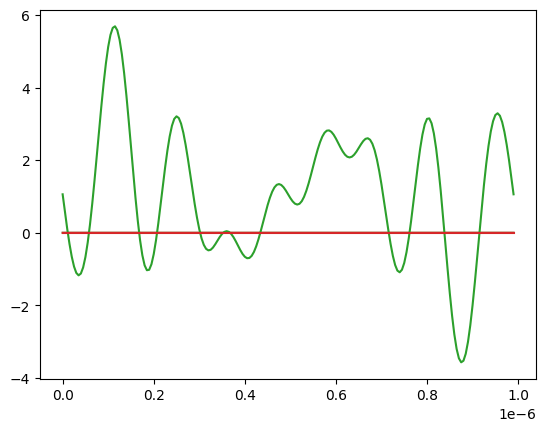

In [433]:
# Fourier series expansion
def fourier_series(t,*coeffs):
    n = len(coeffs[0])
    omega = 2 * np.pi / (t[-1]-t[0])
    f = torch.zeros_like(t, dtype=exp_dtype)
    for i in range(n):
        f += coeffs[0][i].repeat(len(t)) * np.sin(i * omega * t)
    return f

def phi_fourier_series(t, *coeffs):
    n = len(coeffs[0])
    omega = 2 * np.pi / (t[-1]-t[0])
    f = torch.zeros_like(t, dtype=exp_dtype)
    f += coeffs[0][-1]
    for i in range(n-1):
        f += coeffs[0][i].repeat(len(t)) * np.sin(i * omega * t)
    return f

K = 10 # Number of harmonics
scale = 1e4

B_rf_coeffs = Variable(torch.tensor(np.random.randn(K)/scale, dtype=exp_dtype), requires_grad=True) # Random initial coefficients
g_coeffs =  Variable(torch.tensor(np.random.randn(K)/scale, dtype=exp_dtype), requires_grad=True) # Random initial coefficients
phi_coeffs = Variable(torch.tensor(np.random.randn(K+1), dtype=exp_dtype), requires_grad=True) # Random initial coefficients
J_coeffs =  Variable(torch.tensor(np.random.randn(K), dtype=exp_dtype), requires_grad=True) # Random initial coefficients

t_units_tensor = torch.tensor(t_units)

B_rf = fourier_series(t_units_tensor, B_rf_coeffs)
g = fourier_series(t_units_tensor, g_coeffs)
phi = phi_fourier_series(t_units_tensor, phi_coeffs)

g = Variable(torch.tensor(g, dtype=exp_dtype), requires_grad=True)
B_rf = Variable(torch.tensor(B_rf, dtype=exp_dtype), requires_grad=True)
phi = Variable(torch.tensor(phi, dtype=exp_dtype), requires_grad=True)

plt.plot(t_units, B_rf.cpu().detach().numpy())
plt.plot(t_units, g.cpu().detach().numpy())
plt.plot(t_units, phi.cpu().detach().numpy())
plt.plot(t_units, J.cpu().detach().numpy())


In [434]:
# Helper functions to construct Lindbladian superoperator
def kron(A, B):
    return (A[:, None, :, None] * B[None, :, None, :]).reshape(A.shape[0] * B.shape[0], A.shape[1] * B.shape[1])
def kron_einsum(A,B):
    return torch.einsum("ij, kl->ikjl", A, B).view(A.size(0) * B.size(0), A.size(1)* B.size(1))
def hermitian_conj(A):
    return torch.conj(A).transpose(0,1)
def batch_kron(a, b):
    """
    Kronecker product of matrices a and b with leading batch dimensions.
    Batch dimensions are broadcast. The number of them mush
    :type a: torch.Tensor
    :type b: torch.Tensor
    :rtype: torch.Tensor
    """
    siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-2:]))
    res = a.unsqueeze(-1).unsqueeze(-3) * b.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    return res.reshape(siz0 + siz1)

# Define constants
muB = 9.27e-24 # J/T
hbar = 1.055e-34 # Js
B0 = 607.285 * 1e-3 # Tesla, Bohdan's thesis page 120
kB = 1.38e-23 # J/K

w = 2 * muB * B0 / hbar # Larmor freq
on_resonance = False

f_rf = 17e9 # Hz
w_rf = 2 * np.pi * f_rf if not(on_resonance) else w 

# Define Lindblad operators
Te = 4 # K
T1 = 10e-3 # seconds
T2 = 10e-6 # seconds
P_up = 1 / (np.exp(hbar * w / (kB * Te)) + 1)
P_down = 1 - P_up

def L1_j(j, pj, T1, N):
    return U_k(np.sqrt(pj/(2*T1) * sigma_plus), j, N)
def L2_j(j, pj, T1, N):
    return U_k(np.sqrt((1-pj)/(2*T1) * sigma_minus), j, N)
def L3_j(j, T2, N):
    return U_k(np.sqrt(1/(2*np.sqrt(T2)) * sigma_z), j, N)

L1 = []
L2 = []
L3 = []

pj = P_up
for j in range(1, N+1):
    L1.append(L1_j(j, pj, T1, N))
    L2.append(L2_j(j, pj, T1, N))
    L3.append(L3_j(j, T2, N))
L = np.array([L1, L2, L3])


# Construct superoperator 
def construct_superop(g, B_rf, phi, J, L, N, dispersive=False):

    H = torch.zeros((M, 2**(N), 2**(N)), dtype=exp_dtype) # must be faster way ??
    for k in range(1,N+1):
        H += 0.5 * ((1 + g.view(-1, 1, 1)/2) * w - w_rf) * Z_k(k, N).repeat(M, 1, 1) + 0.5 * (2 * muB / hbar) * B_rf.view(-1, 1, 1) * (torch.cos(phi).view(-1, 1, 1) * X_k(k, N).repeat(M, 1, 1) + torch.sin(phi).view(-1, 1, 1) * Y_k(k,N).repeat(M, 1, 1))
    
    for j in range(1, N): # Issue if N > 2
        H += ( J.view(-1,1,1) / (4 * hbar) ) * (X_k(j, N) * X_k(j+1, N) + Y_k(j, N) * Y_k(j+1, N) + Z_k(j, N) * Z_k(j+1, N))

    Gamma = torch.zeros((M, 2**(2 * N), 2**(2 * N)), dtype=exp_dtype)
    for alpha in range(3):
        for j in range(N):
            Gamma += 2 * batch_kron(L[alpha, j].repeat(M,1,1), L[alpha, j].repeat(M,1,1)) - (batch_kron(torch.eye(2**N).repeat(M,1,1), torch.matmul(hermitian_conj(L[alpha,j]), L[alpha,j]).repeat(M,1,1)) + batch_kron(torch.matmul(L[alpha,j].transpose(0,1), L[alpha,j].conj()).repeat(M,1,1), torch.eye(2**N).repeat(M,1,1)))

    L = -1j * (batch_kron(H, torch.eye(2**N).repeat(M,1,1)) - batch_kron(torch.eye(2**N).repeat(M,1,1), H.transpose(1,2))) + int(dispersive) * Gamma
    exp_L = torch.matrix_exp(L * dt)
    L_F = torch.chain_matmul(*exp_L)
    return L_F

t0 = time.time()
L_F = construct_superop(g, B_rf, phi, J, L, N)
print("Time to create superoperator: ", time.time() - t0)

Time to create superoperator:  0.005103111267089844


/var/folders/y1/9bcvzg492znbq7qj0rhkdfp00000gn/T/ipykernel_74440/3788859743.py:56: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  L = np.array([L1, L2, L3])
/var/folders/y1/9bcvzg492znbq7qj0rhkdfp00000gn/T/ipykernel_74440/3788859743.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  L = np.array([L1, L2, L3])


In [435]:
# # Construct superoperator
# def L_F(g, B_rf, phi, J, L, dispersive=False):
#     Gamma = torch.zeros((M, 4, 4), dtype=exp_dtype)
#     for i in range(M):
#         H_rf = 0.5 * ((1 + g[i]/2) * w - w_rf) * sigma_z + 0.5 * (2 * muB / hbar) * B_rf[i] * (torch.cos(phi[i]) * sigma_x + torch.sin(phi[i]) * sigma_y)
#         Gamma[i] = -1j * (kron(H_rf, I) - kron(I, H_rf.transpose(0,1))) + L_total if dispersive else -1j * (kron(H_rf, I) - kron(I, H_rf.transpose(0,1)))
#     exp_Gamma = torch.matrix_exp(Gamma * dt)
#     product = torch.eye(4, dtype=exp_dtype)
#     for matrix in exp_Gamma: # Use torch.einsum? 
#         product = torch.mm(product, matrix)
#     return product

# Evolves rho at each time step and concatonates into an array
# def evolve_rho(rho0, B_rf, g, phi, dispersive=False):
#     rhos = torch.zeros((M, 2, 2), dtype=exp_dtype)
#     rhos[0] = rho0
#     Gamma = torch.zeros((M, 4, 4), dtype=exp_dtype)
#     for i in range(M):
#         H_rf = 0.5 * ((1 + g[i]/2) * w - w_rf) * sigma_z + 0.5 * (2 * muB / hbar) * B_rf[i] * (torch.cos(phi[i]).item() * sigma_x + torch.sin(phi[i]).item() * sigma_y)
#         Gamma[i] = -1j * (kron(H_rf, I) - kron(I, H_rf.transpose(0,1))) + L_total if dispersive else -1j * (kron(H_rf, I) - kron(I, H_rf.transpose(0,1)))
#     exp_Gamma = torch.matrix_exp(Gamma * dt)
#     for i in range(1,M): # should be more efficient way
#         rhos[i] = torch.matmul(exp_Gamma[i], rhos[i-1].view(-1,)).view(2,2)
#     return rhos, rhos.detach().numpy()

### Desired operator
def RX(theta):
    return torch.from_numpy(np.array([[np.cos(theta/2), -1j * np.sin(theta/2)], [-1j * np.sin(theta/2),np.cos(theta/2)]])).type(exp_dtype)
def RY(theta):
    return torch.from_numpy(np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2),np.cos(theta/2)]])).type(exp_dtype)

theta =np.pi/2

UF_ = RX(theta)
UF = torch.kron(UF_, torch.eye(2)) if N==2 else UF_

L_desired = torch.kron(UF.conj(), UF)

# Check out density matrices
rho0_spin1 =  torch.from_numpy(np.array([[1,0],[0,0]])).type(exp_dtype) # psi0 = |g>
rho0_spin2 =  torch.from_numpy(np.array([[1,0],[0,0]])).type(exp_dtype) # psi0 = |g>
rho0 = torch.kron(rho0_spin1, rho0_spin2) if N == 2 else rho0_spin1

rho_desired = torch.matmul(
            L_desired, rho0.view(-1,)
        )
rho = torch.matmul(
            construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive), rho0.view(-1,)
        )

print(rho_desired.view(2**N,2**N))
print(rho.view(2**N,2**N))



tensor([[0.5000+0.0000j, 0.0000-0.5000j],
        [0.0000+0.5000j, 0.5000+0.0000j]])
tensor([[ 0.7197+3.9796e-05j, -0.4331-1.1826e-01j],
        [-0.4331+1.1810e-01j,  0.2801-3.9804e-05j]], grad_fn=<ViewBackward0>)


In [436]:
from torch.fft import fft

class CostFunction(nn.Module):
    def __init__(self):
        super(CostFunction, self).__init__()

    def fidelity(self, output, target):
        fid = torch.abs(torch.trace(
            torch.mm(
                hermitian_conj(output), target
            )
        )) / (2**(2*N))

        return fid
    
    def forward(self, output, target):

        fid = self.fidelity(output,target)

        euclidean_dist = nn.L1Loss()

        return torch.square(fid-1) + euclidean_dist(output,target), fid

opt_params = [g_coeffs.to(device), B_rf_coeffs.to(device), phi_coeffs.to(device)]
lr_dict = {'g': 1e-6, 'B_rf': 1e-5, 'phi': 1e-2, 'J': 1e-29}
optimizer = torch.optim.Adam(
        [{'params': g_coeffs, 'lr': lr_dict['g']},
         {'params': B_rf_coeffs, 'lr': lr_dict['B_rf']},
         {'params': phi_coeffs, 'lr': lr_dict['phi'],},
         {'params': J, 'lr': lr_dict['J']}],
        )

criterion = CostFunction()

epochs = 500
loss_array = []

for i in range(epochs):
    
    optimizer.zero_grad()

    B_rf = fourier_series(t_units_tensor, B_rf_coeffs)
    g = fourier_series(t_units_tensor, g_coeffs)
    phi = phi_fourier_series(t_units_tensor, phi_coeffs)

    L_output = construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive)
    
    loss, fid = criterion(L_output, L_desired)

    loss.backward()
    optimizer.step()

    loss_array.append(loss.item())
 
    if i % 50 == 0:
        print("Step {}: Loss = {}, Fidelity = {}".format(i, loss.item(), fid))

    if fid > 0.99999 and fid < 1:
        break


Step 0: Loss = 0.6429492831230164, Fidelity = 0.5503576993942261
Step 50: Loss = 0.02285655401647091, Fidelity = 1.0004163980484009
Step 100: Loss = 0.009189983829855919, Fidelity = 0.9996086955070496
Step 150: Loss = 0.01562450174242258, Fidelity = 0.9998186826705933
Step 200: Loss = 0.02486344240605831, Fidelity = 1.0008412599563599


In [437]:
L_output = construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive)

print("Output superoperator, \n ",L_output )
print("Desired superoperator, \n ", L_desired)
print("Final Fidelity = ",fid)

# See what L_f does to initial state
rho_out = torch.matmul(
            L_output, rho0.view(-1,)
        )
print(rho_out)

def fidelity_states(rho, sigma):
    # sigma is output 
    sqrt_rho = torch.pow(rho, 0.5)
    temp_mat = torch.mm(sqrt_rho, torch.mm(sigma, sqrt_rho))

    return torch.square(torch.trace(torch.pow(temp_mat, 0.5)))

rho_out = rho_out.view(2**N,2**N)
rho_theoretical = rho_desired.view(2**N,2**N)
print("Rho Out: \n", rho_out)
print("Rho Desired: \n", rho_theoretical)
print("Rho fidelity: ", fidelity_states(rho_theoretical, rho_out))

Output superoperator, 
  tensor([[ 0.5032-0.0131j,  0.0050-0.5194j,  0.0043+0.4811j,  0.4965+0.0131j],
        [-0.0036-0.5060j,  0.5290-0.0126j,  0.4838+0.0049j,  0.0035+0.5059j],
        [-0.0039+0.4939j,  0.5093+0.0221j,  0.4782-0.0134j,  0.0038-0.4938j],
        [ 0.4966+0.0131j, -0.0051+0.5193j, -0.0044-0.4811j,  0.5030-0.0131j]],
       grad_fn=<ViewBackward0>)
Desired superoperator, 
  tensor([[0.5000+0.0000j, 0.0000-0.5000j, 0.0000+0.5000j, 0.5000+0.0000j],
        [0.0000-0.5000j, 0.5000+0.0000j, 0.5000+0.0000j, 0.0000+0.5000j],
        [0.0000+0.5000j, 0.5000+0.0000j, 0.5000+0.0000j, 0.0000-0.5000j],
        [0.5000+0.0000j, 0.0000+0.5000j, 0.0000-0.5000j, 0.5000+0.0000j]])
Final Fidelity =  tensor(1.0000, grad_fn=<DivBackward0>)
tensor([ 0.5032-0.0131j, -0.0036-0.5060j, -0.0039+0.4939j,  0.4966+0.0131j],
       grad_fn=<MvBackward0>)
Rho Out: 
 tensor([[ 0.5032-0.0131j, -0.0036-0.5060j],
        [-0.0039+0.4939j,  0.4966+0.0131j]], grad_fn=<ViewBackward0>)
Rho Desired: 
 ten

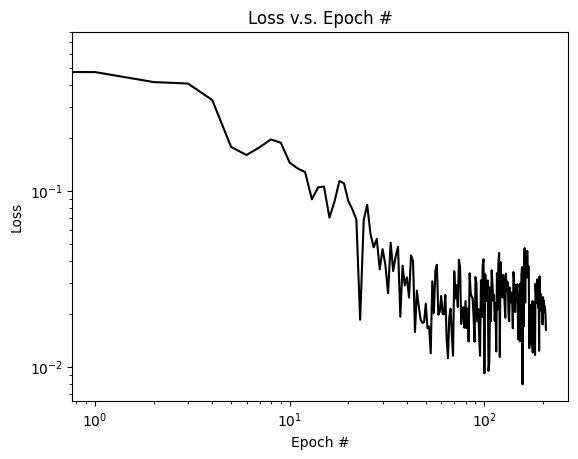

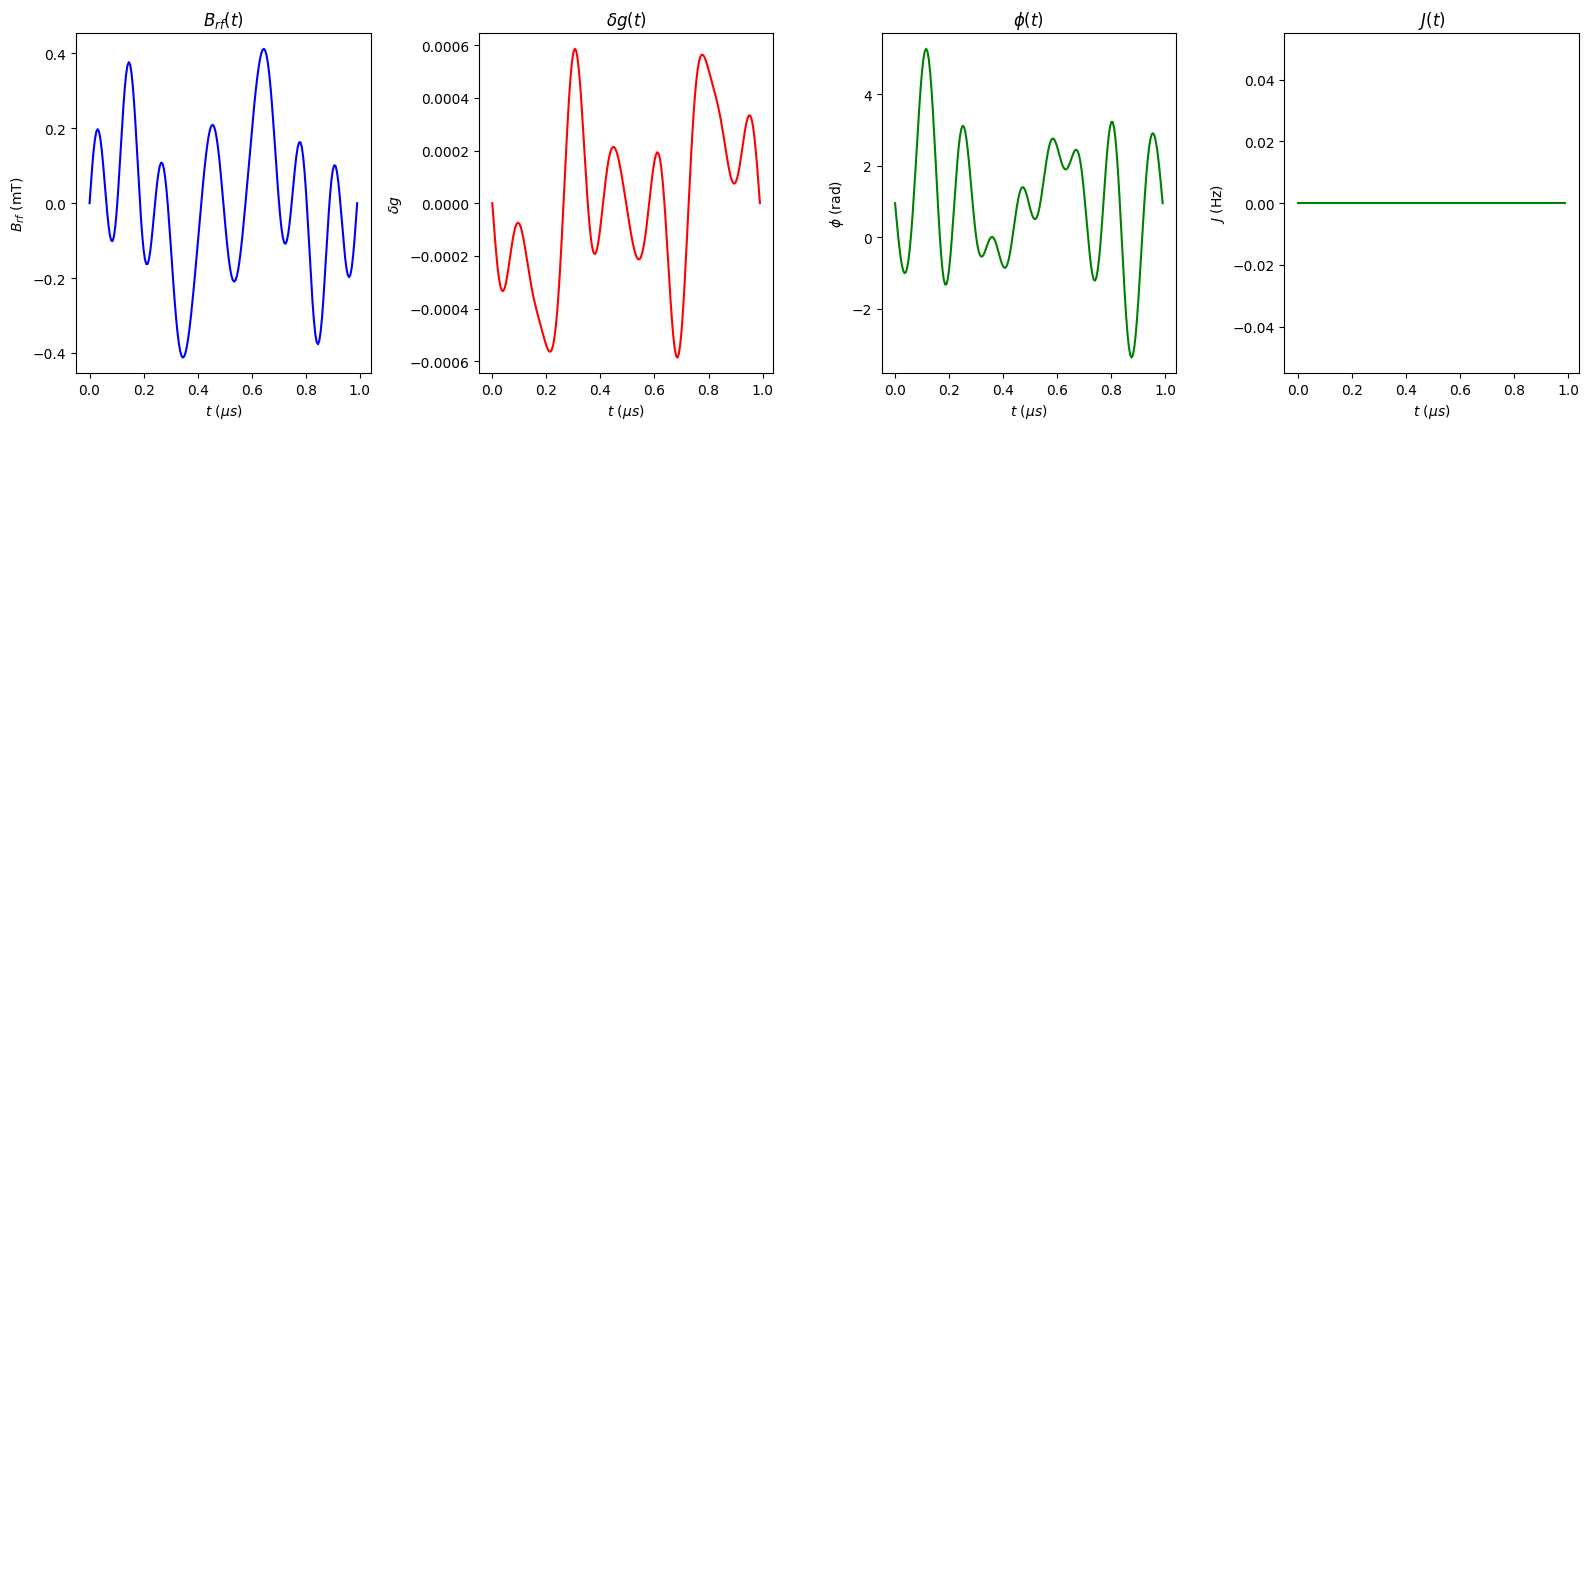

In [438]:

# Print cost fxn 
plt.loglog(loss_array, 'k')
plt.title("Loss v.s. Epoch #")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.savefig('./results/loss.png', dpi=350, bbox_inches="tight")
plt.show()

# Show trained parameters
plt.plot(1e6 * t_units, 1e3 * B_rf.detach().numpy(), 'b')
plt.title(r"$B_{rf}(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$B_{rf}\ $(mT)")
plt.savefig('./results/B_rf.png', dpi=350, bbox_inches="tight")
plt.close()
# plt.show() 

plt.plot(1e6 * t_units, g.detach().numpy(), 'r')
plt.title(r"$\delta g(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$\delta g$")
plt.savefig('./results/delta_g.png', dpi=350, bbox_inches="tight")
plt.close()
# plt.show() 

plt.plot(1e6 * t_units, phi.detach().numpy(), 'g')
plt.title(r"$\phi(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$\phi$ (rad)")
plt.savefig('./results/phi.png', dpi=350, bbox_inches="tight")
plt.close()
# plt.show()

plt.plot(1e6 * t_units, J.detach().numpy(), 'g')
plt.title(r"$J(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$J$ (Hz)")
plt.savefig('./results/J.png', dpi=350, bbox_inches="tight")
plt.close()
# plt.show()

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Plot B_rf
axs[0, 0].plot(1e6 * t_units, 1e3 * B_rf.detach().numpy(), 'b')
axs[0, 0].set_title(r"$B_{rf}(t)$")
axs[0, 0].set_xlabel(r'$t\ (\mu s)$')
axs[0, 0].set_ylabel(r"$B_{rf}\ $(mT)")

# Plot delta g
axs[0, 1].plot(1e6 * t_units, g.detach().numpy(), 'r')
axs[0, 1].set_title(r"$\delta g(t)$")
axs[0, 1].set_xlabel(r'$t\ (\mu s)$')
axs[0, 1].set_ylabel(r"$\delta g$")

# Plot phi
axs[0, 2].plot(1e6 * t_units, phi.detach().numpy(), 'g')
axs[0, 2].set_title(r"$\phi(t)$")
axs[0, 2].set_xlabel(r'$t\ (\mu s)$')
axs[0, 2].set_ylabel(r"$\phi$ (rad)")

# Plot J
axs[0, 3].plot(1e6 * t_units, J.detach().numpy(), 'g')
axs[0, 3].set_title(r"$J(t)$")
axs[0, 3].set_xlabel(r'$t\ (\mu s)$')
axs[0, 3].set_ylabel(r"$J$ (Hz)")

# Remove empty subplots
for i in range(1, 4):
    for j in range(4):
        axs[i, j].axis('off')

# Adjust spacing between subplots
plt.tight_layout()
